# Masked Language Modeling

This notebook describes how one can pre-train their own AntiBERTa model using the HuggingFace framework. As a demo, we've included the tokenizer we've used, and 1% of the sequences that we used in our training, validation, and test sets of the paper.

In [1]:
# initialise the workspace
workdir = "C:/Users/XTM23/Documents/@PARA/y2023/309-UROP/test-antiberta" # when relative path fails

## Setup of all the things we need

In [6]:
# Some imports 
from transformers import (
    RobertaConfig,
    RobertaTokenizer,
    RobertaForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset
import os
import shutils
import torch
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Initialise the tokeniser
tokenizer = RobertaTokenizer.from_pretrained("antibody-tokenizer")

# Initialise the data collator, which is necessary for batching
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [2]:
# transform json files into dataframe

def read_log(filepath):
    """
    Arg:
        filepath a string representing path of .json file
    """
    js = pd.read_json(filepath)
    s = js["best_model_checkpoint"][0] # the directory of best checkpoint
    best_model_checkpoint = int(s.split("-")[-1]) # the number of steps at which the best metric is obtained
    lst = filepath.split("checkpoint-")
    lst = lst[1].split("/")
    total_steps = int(lst[0])
    df = pd.json_normalize(js["log_history"])
    n = len(df)
    # dataframe contianing eval loss
    odd_indx = np.array([i for i in range(n) if i%2 == 1])
    df1 = df.loc[odd_indx,:]
    # dataframe contianing train loss
    even_indx = np.array([i for i in range(n) if i%2 == 0])
    df2 = df.loc[even_indx,:]
    # if use_epoch:
    #     df1 = df1[["epoch", "eval_loss"]]
    #     df2 = df2[["epoch", "loss"]]
    #     df3 = df1.join(df2.set_index('epoch'), on='epoch')
    # else:
    df1 = df1[["step", "eval_loss"]]
    df2 = df2[["step", "loss"]]
    df3 = df1.join(df2.set_index('step'), on='step')
    return df3,js["best_metric"][0],best_model_checkpoint, total_steps

In [116]:
def generate_path(i, j, k):
    # return path of the latest checkpoint json file for specified model
    s = "-".join(["train",str(i),str(j),str(k)])
    lst = os.listdir("finished/"+s+"/test")
    cps = []
    for d in lst:
        i = int(d.split("-")[-1])
        cps.append(i)
    cps.sort()
    path = "/".join(["finished",s,f"test/checkpoint-{cps[-1]}","trainer_state.json"])
    return path

In [118]:
# auxillary scirpts
# put all the logs into respective dataframe
log_dic = {}
for i in range(1,5):
    # n_head
    for j in range(1,5):
        # n_layer
        for k in range(10):
            df, best_metric, best_model_checkpoint, total_steps = read_log(generate_path(i,j,k))
            sub_dic = {"df": df, "best_metric":best_metric,"best_model_cp_step":best_model_checkpoint,"total_steps":total_steps}
            log_dic[(i,j,k)] = sub_dic
# move models into one
# rename 

In [119]:
# create array for hyperparameter search that stores best result for each model
df_hs = np.zeros((4,4,10)) 
for i in range(4):
    for j in range(4):
        for k in range(10):
            df_hs[i,j,k] = log_dic[(i+1,j+1,k)]["best_metric"]
# get average of each set of hyperparameters over different ways of splitting datasets
mat_hs = np.mean(df_hs, axis=2)


In [120]:
df = pd.DataFrame(mat_hs, columns = ['1 layer','2 layers','3 layers', "4 layers"], index = ['1 head', '2 heads', "3 heads", "4 heads"])

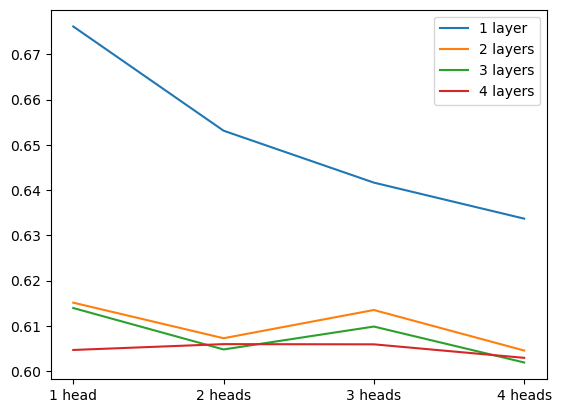

In [121]:
plt.plot(df, label=['1 layer','2 layers','3 layers', "4 layers"])
plt.legend()

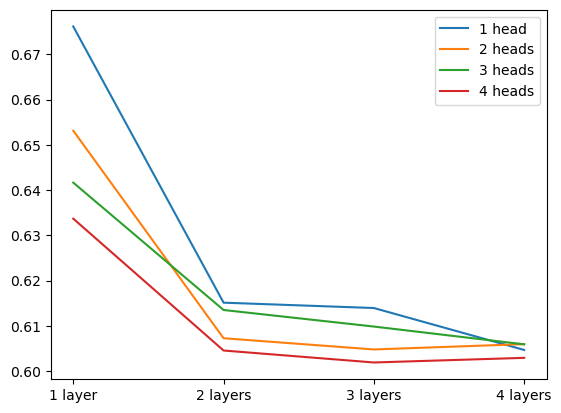

In [122]:
df = pd.DataFrame(mat_hs.transpose(), index = ['1 layer','2 layers','3 layers', "4 layers"], columns = ['1 head', '2 heads', "3 heads", "4 heads"])
plt.plot(df, label=['1 head', '2 heads', "3 heads", "4 heads"])
plt.legend()

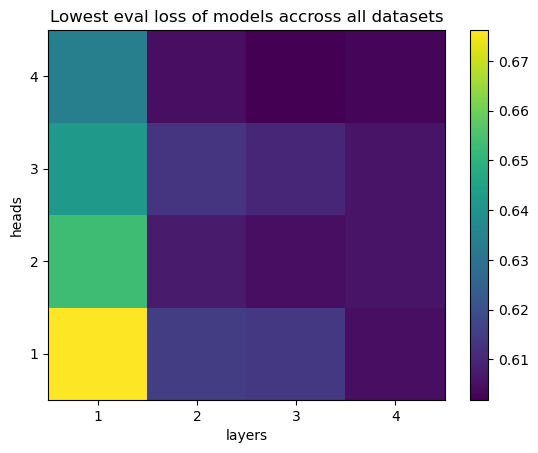

In [126]:
fig, ax= plt.subplots()
ticks = [1,2,3,4]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis')
ax.set_xlabel("layers")
ax.set_ylabel("heads")
ax.set_title("Lowest eval loss of models accross all datasets")
fig.colorbar(c, ax=ax)

In [190]:
def list2txt(lst,filepath, overwrite=True):
    """
    save content of a list into text file
    Args:
        lst: a list of tuples
        filepath: a string indicating the path of a text file
    """
    # clear file content before writing
    if not overwrite:
        with open(filepath, 'a') as f:
            for line in lst:
                f.write(str(line)+"\n")
    else:
        with open(filepath, 'w') as f:
            for line in lst:
                f.write(str(line)+"\n")

In [192]:
train_array = []
for s in ["6-2","6-3","6-4","6-5", "4-5","3-5","2-5","1-5", "6-1"]:
    i, j = tuple(s.split("-"))
    for k in range(5):
        train_array.append((int(i),int(j),k))
for s in ["6-2","6-3","6-4","6-5", "4-5","3-5","2-5","1-5", "6-1"]:
    i, j = tuple(s.split("-"))
    for k in range(5,10):
        train_array.append((int(i),int(j),k))

list2txt(train_array,"TEST.txt")

In [130]:
def imshow_single_dataset(i):
    mat_hs = df_hs[:,:,i]
    fig, ax= plt.subplots()
    ticks = [1,2,3,4]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis')
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    ax.set_title(f"Lowest eval loss of models accross the dataset {i}")
    fig.colorbar(c, ax=ax)

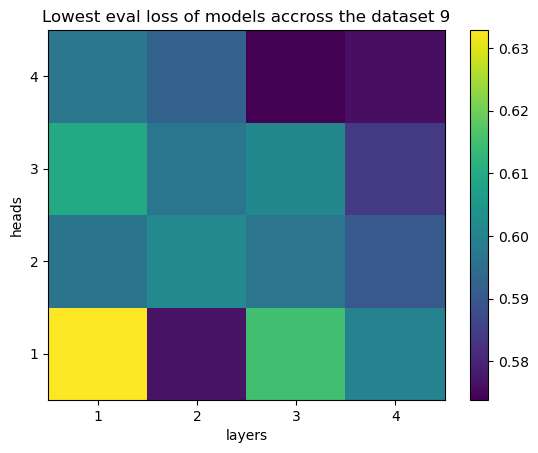

In [131]:
imshow_single_dataset(9)

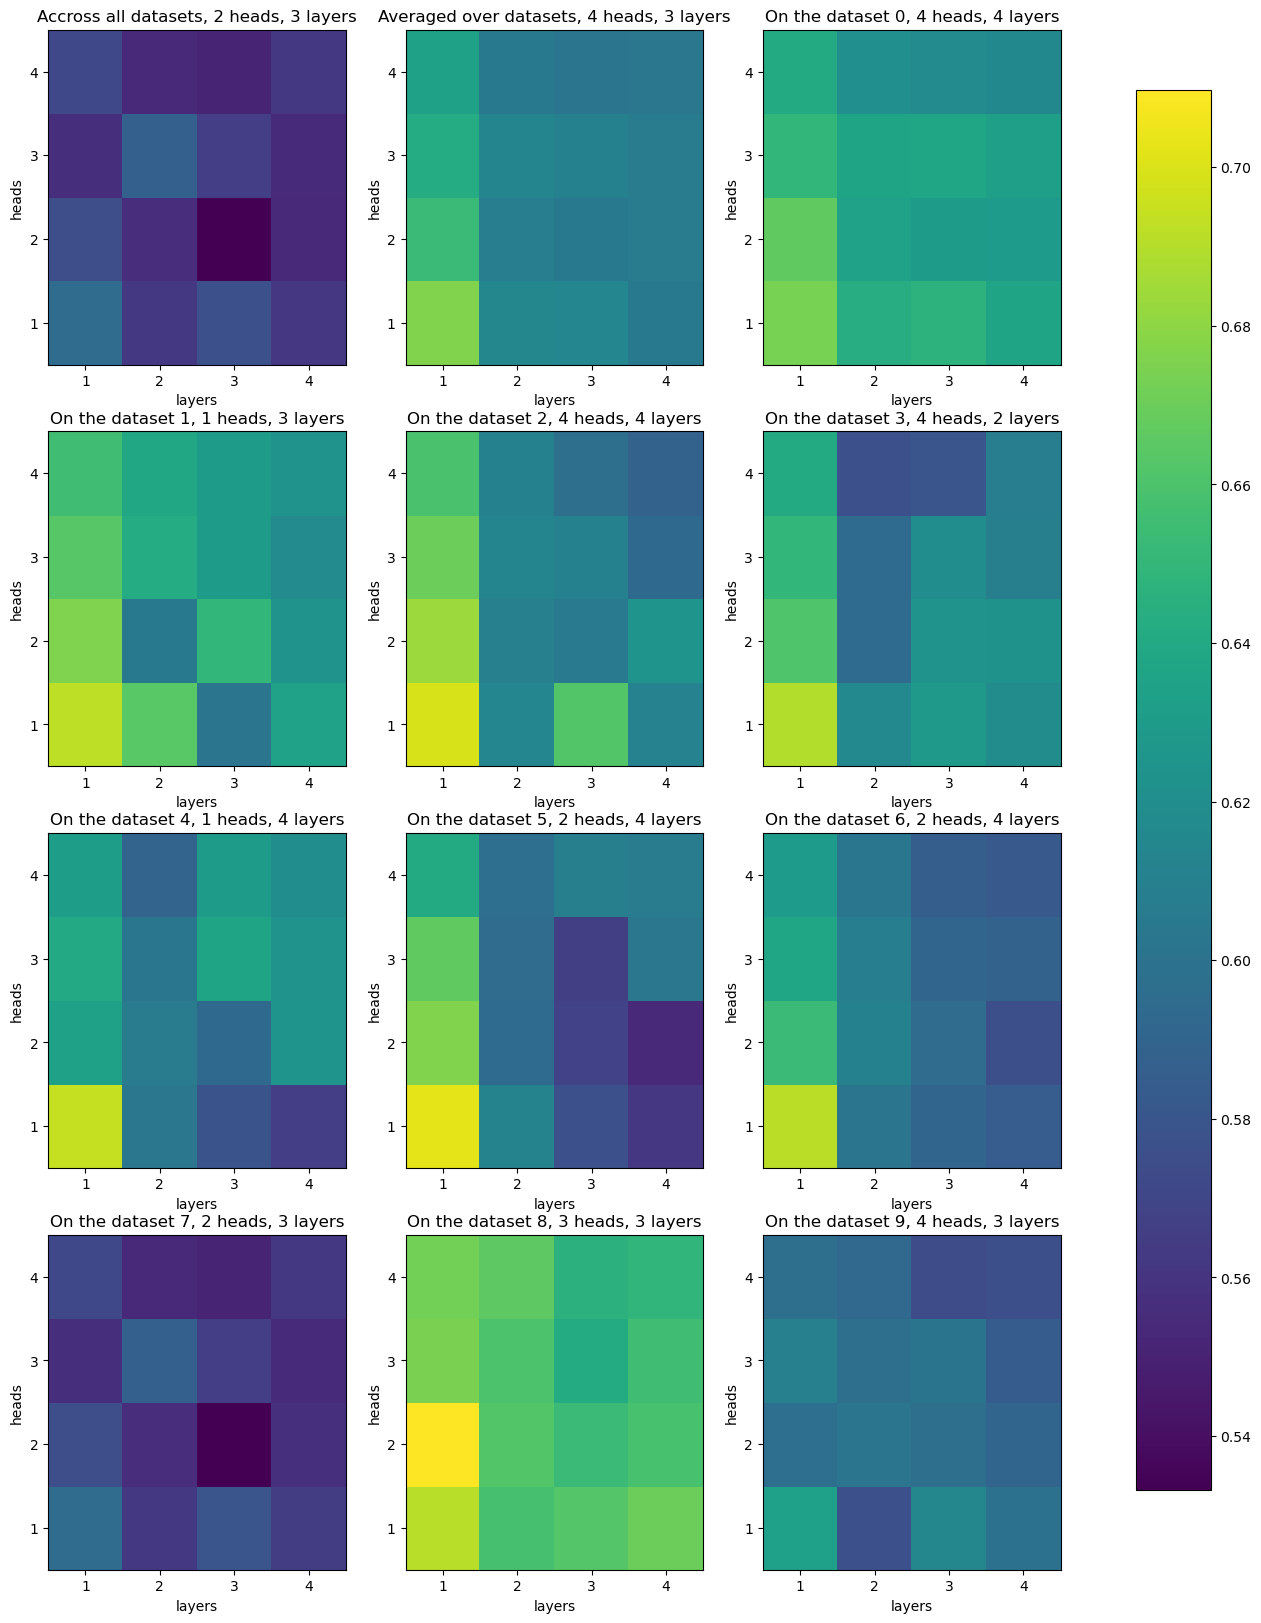

In [132]:
fig, axes = plt.subplots(4,3)
fig.set_figheight(20)
fig.set_figwidth(15)
ticks = [1,2,3,4]
for i in range(12):
    ax = axes[i//3, i%3]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    if i == 0:
        mat_hs = np.min(df_hs, axis=2)
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"Accross all datasets, {j+1} heads, {k+1} layers")
    elif i == 1:
        mat_hs = np.mean(df_hs, axis=2)
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"Averaged over datasets, {j+1} heads, {k+1} layers")     
    else:
        mat_hs = df_hs[:,:,i-2]
        j,k = np.unravel_index(mat_hs.argmin(),shape=(4,4))
        ax.set_title(f"On the dataset {i-2}, {j+1} heads, {k+1} layers")
    c = ax.pcolor(ticks, ticks, mat_hs, cmap='viridis', vmin=np.min(df_hs), vmax=np.max(df_hs))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(c, ax=ax)
fig.colorbar(c, cax=cbar_ax)


In [143]:
count = 0
for i,key in enumerate(log_dic):
    item = log_dic[key]
    diff = item["best_model_cp_step"]-item["total_steps"]
    if diff != -500:
        print(key)
        count +=1

(1, 3, 1)
(3, 3, 4)


In [144]:
# create array for hyperparameter search that stores best result for each model
df_speed = np.zeros((4,4,10)) 
for i in range(4):
    for j in range(4):
        for k in range(10):
            df_speed[i,j,k] = log_dic[(i+1,j+1,k)]["best_model_cp_step"]
# get average of each set of hyperparameters over different ways of splitting datasets
# mat_hs = np.mean(df_hs, axis=2)

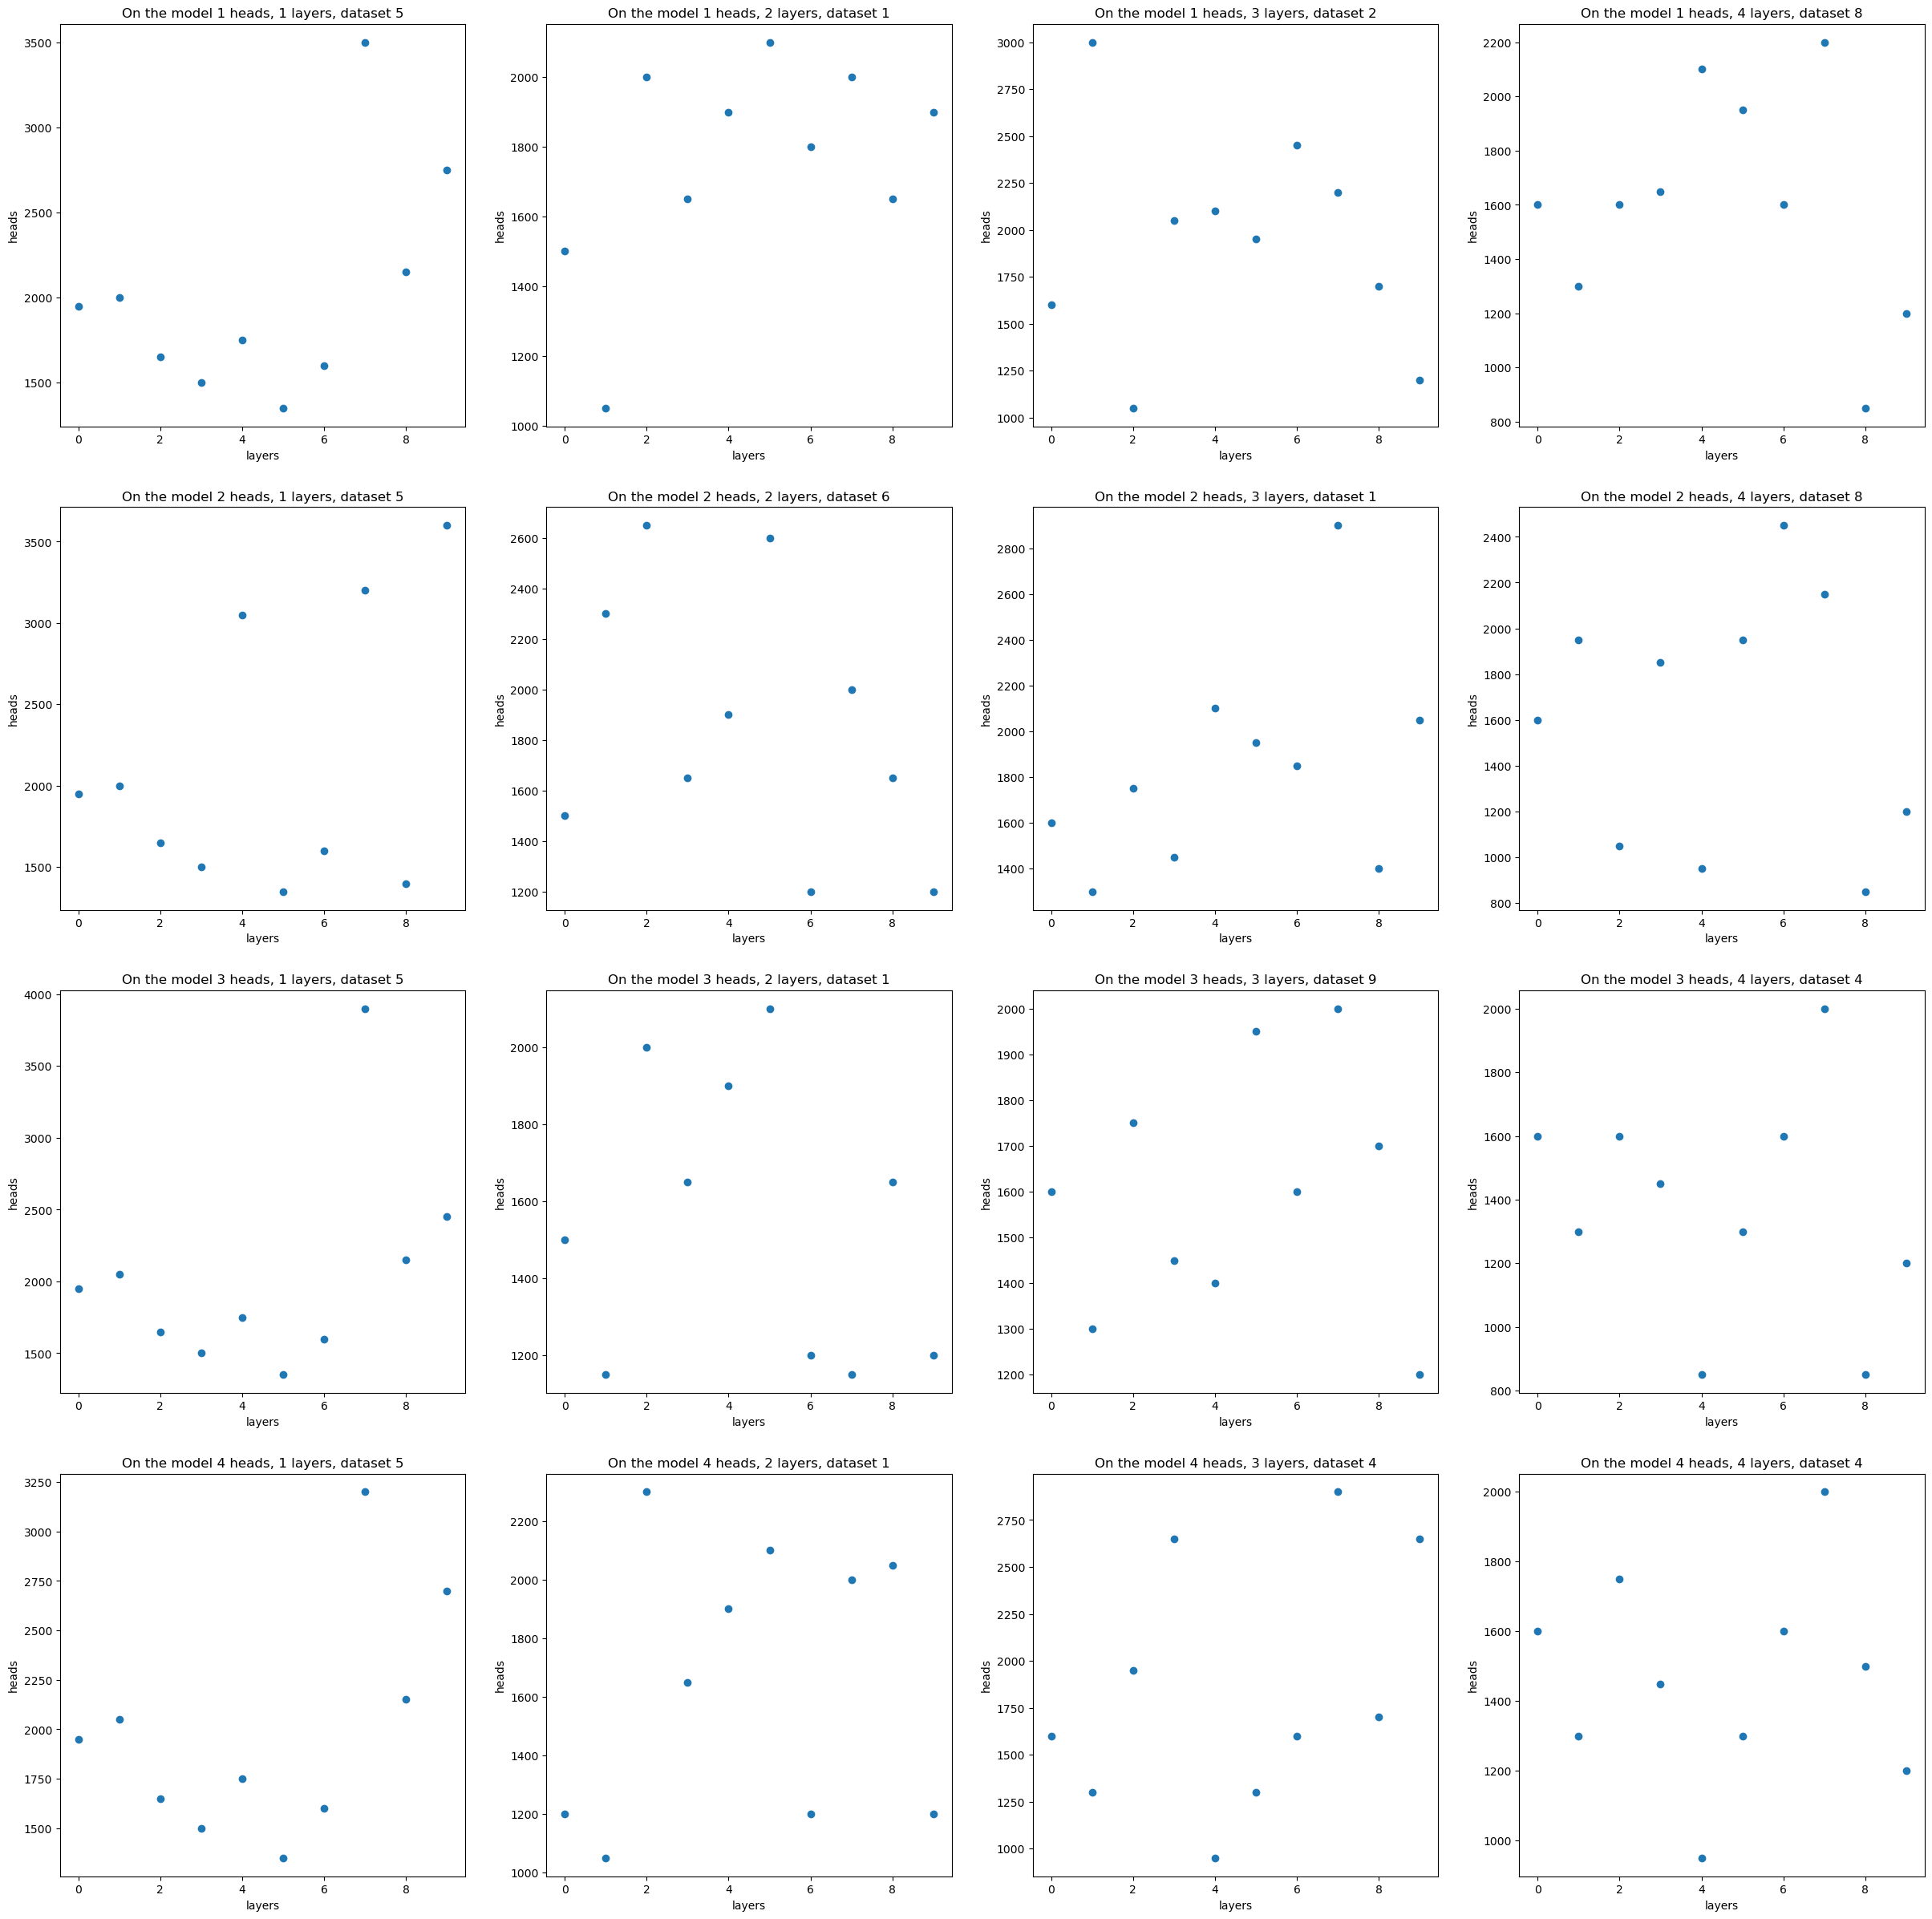

In [161]:
fig, axes = plt.subplots(4,4)
fig.set_figheight(30)
fig.set_figwidth(30)
lst = []
# ticks = [1,2,3,4]
for i in range(16):
    ax = axes[i//4, i%4]
    ax.set_xlabel("layers")
    ax.set_ylabel("heads")
    mat_speed = df_speed[i//4, i%4,:]
    # j,k = np.unravel_index(mat_speed.argmin(),shape=(4,4))
    j = mat_speed.argmin()
    ax.set_title(f"On the model {i//4+1} heads, {i%4+1} layers, dataset {j}")
    ax.scatter(np.arange(10),mat_speed)
    lst.append(j)
    # c = ax.pcolor(ticks, ticks, mat_speed, cmap='viridis', vmin=np.min(df_speed), vmax=np.max(df_speed))
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(c, ax=ax)
# fig.colorbar(c, cax=cbar_ax)

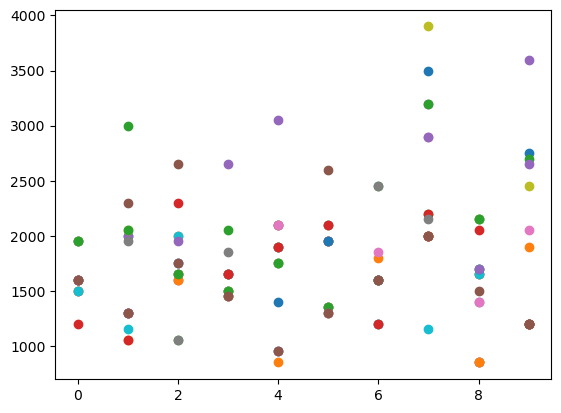

In [166]:
for i in range(16):
    mat_speed = df_speed[i//4, i%4,:]
    plt.scatter(np.arange(10),mat_speed, label=f"{i//4}heads,{i%4}layers")

[5, 1, 2, 8, 5, 6, 1, 8, 5, 1, 9, 4, 5, 1, 4, 4]

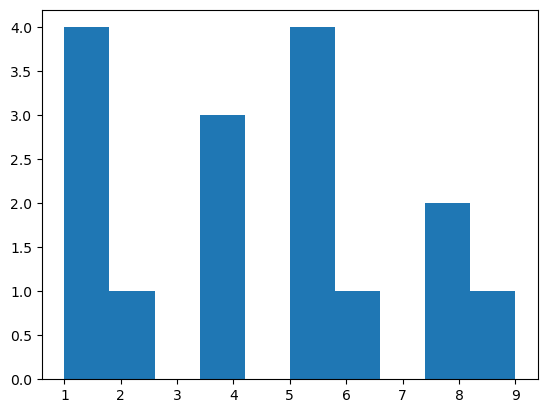

In [157]:
plt.hist(lst,bins=10) # 1,4,5,8,2,6,9
lst

In [134]:
# sanity check through site 97
def extract_prob():
    """
    Return a dictionary with the structure:
        "model": a tuple, (n_heads, n_layers)
        "random_index": an integer, index number of random datasets
        "prob_map_unsorted": a Nx20 numpy array
        "prob_map_sorted": a Nx20 numpy array
    """
    
def prob_at_site(index, probs=probs_mlm):
    # index: integer, position at aligned sequences
    # return: an array of n_seqx25
    n_seq = len(probs)
    output = np.zeros((n_seq,20))
    for i in range(n_seq):
        output[i,:] = probs_mlm[i][index,:]
    return output

2

In [135]:
plot_df,_,_,_ = read_log("test/checkpoint-58900/trainer_state.json")

Text(0.5, 1.0, 'Loss against steps')

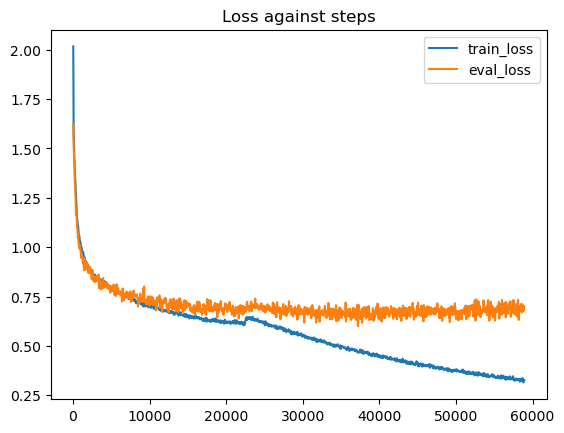

In [11]:
plt.plot(plot_df["step"], plot_df["loss"], label="train_loss")
plt.plot(plot_df["step"], plot_df["eval_loss"], label="eval_loss")
plt.legend()
plt.title("Loss against steps")

## Collate prediction outputs

In [ ]:
# specify the model used

model = RobertaForMaskedLM.from_pretrained("./model/1-1-1")

In [24]:
# TODO run this cell
probs = []
for s in final_indices:
#for s in range(1,2):
    # for a given seq, convert each symbol to a number (position along the alphabet)
    # and add a begind/end symbol
    # token_ids = tokenizer.encode(seqs[s], return_tensors='pt')
    token_ids = tokenizer.encode(seqs_al[s], return_tensors='pt') # to maintain a homogeneous shape
    #train
    # take the model and calculate the MaskedLMOutput, take its logits
    # which are in a matrix with size # tokens x # symbols 
    ## (note: it's a single-sequence embedding)
    out = model(token_ids)
    mat = out['logits'].squeeze()
    
    ## calculate attention of each token, which is a probability conditional on the rest of the sequence
    ## to obtain a probability, one normalizes over the column (possible symbols at that position)
    ## and flatten everything into a vector of length # tokens x # symbols
    prob = torch.nn.functional.softmax(mat, dim=1).detach().numpy()
    probs.append(prob)
    # add progress indicator
    if s%10 == 0:
        print(f"{(s+1)/len(final_indices)} done")

0.0003178639542275906 done
0.0034965034965034965 done
0.006675143038779402 done
0.009853782581055308 done
0.013032422123331213 done
0.01621106166560712 done
0.019389701207883026 done
0.02256834075015893 done
0.02574698029243484 done
0.028925619834710745 done
0.032104259376986646 done
0.035282898919262555 done
0.038461538461538464 done
0.041640178003814365 done
0.044818817546090274 done
0.04799745708836618 done
0.051176096630642084 done
0.05435473617291799 done
0.057533375715193895 done
0.060712015257469804 done
0.0638906547997457 done
0.06706929434202162 done
0.07024793388429752 done
0.07342657342657342 done
0.07660521296884933 done
0.07978385251112524 done
0.08296249205340114 done
0.08614113159567705 done
0.08931977113795296 done
0.09249841068022886 done
0.09567705022250476 done
0.09885568976478068 done
0.10203432930705658 done
0.10521296884933248 done
0.10839160839160839 done
0.1115702479338843 done
0.1147488874761602 done
0.1179275270184361 done
0.12110616656071202 done
0.1242848061

In [25]:
np.shape(probs[4])

(130, 25)

In [26]:
entropies_t=[]
entropies_p=[]
mapping_indices_seq=[]
for s in range(len(final_indices)):
    token_ids = tokenizer.encode(seqs[final_indices[s]], return_tensors='pt')

    seq1 = seqs[final_indices[s]]
    seq2 = seqs_al[final_indices_al[s]]

    #print(seq1)
    #print(seq2)

    indices_al = [] # collate indices of symbols on aligned seq that are not gap
    i = 0
    j = 0
    while i < len(seq1) and j < len(seq2): # double pointers
        if seq1[i] == seq2[j]:
            indices_al.append(j)
            i += 1
        j += 1
        
    
    ## Check consistent def of indices ##
    list1=[]
    list2=[]
    for i in range(len(seqs[final_indices[s]])):
        list1.append(seqs[final_indices[s]][i])
        #print(indices_al[i])
        ip = indices_al[i]
        list2.append(seqs_al[final_indices_al[s]][ip])
    #plt.scatter(list1,list2), should be  y=x

    
    ## single-sequence, single-site entropy ##
    ent_t = [] 
    ent_p = [] 
    c=0
    uu=[]
    for i in range(1,len(token_ids.squeeze())-1): # I don't consider end and start of the sequence added by the embedding
        ## position ##
        a = int(token_ids.squeeze()[i])
        uu.append(a)
        ## HERE: possible I need to exclude from entropy 
        ## computation the unphysical variables, like mask, pad, start/end etc
        ent_t.append(sum(-(probs[s][i][:])*np.log2(probs[s][i][:]+1/Mb)))
        ip = indices_al[c]
        #mapping_indices.append(ip)
        c+=1
        #sym = seqs_al[final_indices_al[s]][ip]
        #a = vocab[sym]
        ## here too I might need to exclude the unphysical symbols, 
        ## but they have zero frequency in any case, just I need to 
        ## re-do the normalization over the new set of symbols!!
        ent_p.append(sum(-pwm[ip,pwm[ip,:]>0]*np.log2(pwm[ip,pwm[ip,:]>0])))

    ## check consistency ##
    str1=''
    str2 = str1.join([vocab_inv[u] for u in uu])
    #print(seq1==str2)
    
    entropies_t.append(ent_t)
    entropies_p.append(ent_p)
    mapping_indices_seq.append(indices_al)
    

In [27]:
pwm[0,pwm[0,:]>0]

array([6.6751428e-02, 8.5823266e-03, 9.5359184e-04, 1.6528925e-02,
       3.6236492e-01, 1.5893198e-03, 2.2250477e-03, 2.8607757e-03,
       1.2714558e-03, 1.5893198e-03, 1.2714558e-03, 6.3572789e-04,
       5.2638268e-01, 3.1786396e-03, 1.9071837e-03, 3.1786395e-04,
       1.5893198e-03], dtype=float32)

In [28]:
ref=19 # TODO try more different sequences
vec1=np.array(entropies_p[ref])
vec2=np.array(entropies_t[ref])

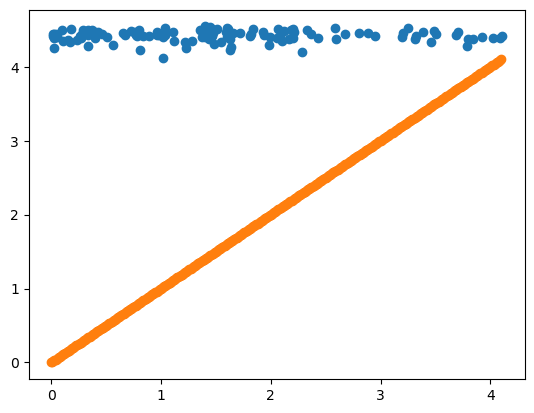

In [29]:
plt.scatter(vec1,vec2)
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))

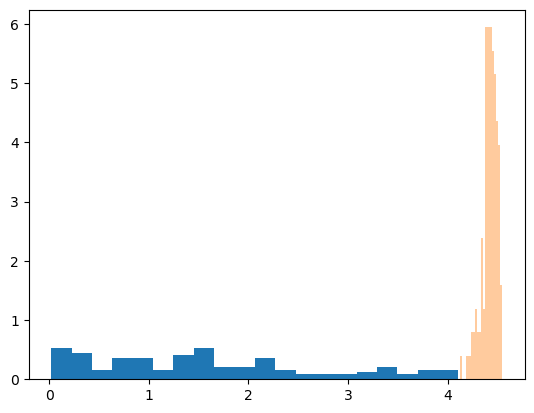

In [30]:
plt.hist(vec1, density=True, bins=20); #CIE
plt.hist(vec2,alpha=0.4, density=True, bins=20); #CDE

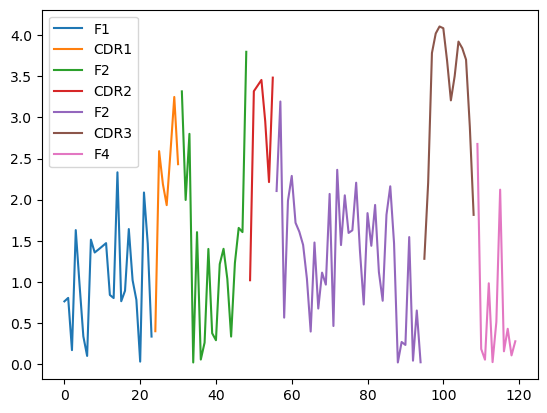

In [31]:
b_cdr1n = mapping_indices_seq[ref].index(b_cdr1) # complementary determining matrix
e_cdr1n = mapping_indices_seq[ref].index(e_cdr1)
b_cdr2n = mapping_indices_seq[ref].index(b_cdr2)
e_cdr2n = mapping_indices_seq[ref].index(e_cdr2)
b_cdr3n = mapping_indices_seq[ref].index(b_cdr3)
e_cdr3n = mapping_indices_seq[ref].index(e_cdr3)


import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1n), vec1[:b_cdr1n], label='F1')
plt.plot(np.arange(b_cdr1n,e_cdr1n), vec1[b_cdr1n:e_cdr1n], label='CDR1')
plt.plot(np.arange(e_cdr1n, b_cdr2n), vec1[e_cdr1n: b_cdr2n], label='F2')
plt.plot(np.arange(b_cdr2n, e_cdr2n), vec1[b_cdr2n:e_cdr2n], label='CDR2')
plt.plot(np.arange(e_cdr2n, b_cdr3n), vec1[e_cdr2n: b_cdr3n], label='F2')
plt.plot(np.arange(b_cdr3n,e_cdr3n), vec1[b_cdr3n:e_cdr3n], label='CDR3')
plt.plot(np.arange(e_cdr3n, len(seqs[ref])), vec1[e_cdr3n:], label='F4')
plt.legend()

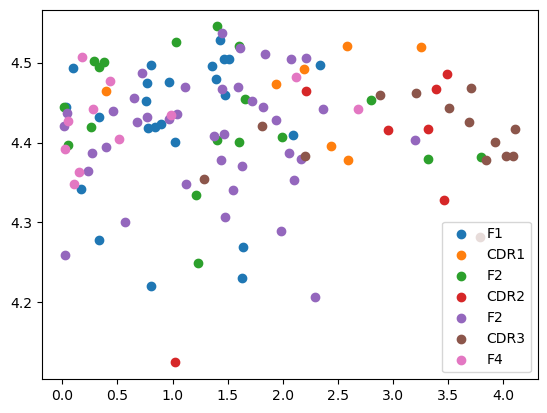

In [32]:
plt.scatter(vec1[:b_cdr1n], vec2[:b_cdr1n], label='F1')
plt.scatter(vec1[b_cdr1n:e_cdr1n], vec2[b_cdr1n:e_cdr1n], label='CDR1')
plt.scatter(vec1[e_cdr1n: b_cdr2n], vec2[e_cdr1n: b_cdr2n], label='F2')
plt.scatter(vec1[b_cdr2n:e_cdr2n], vec2[b_cdr2n:e_cdr2n], label='CDR2')
plt.scatter(vec1[e_cdr2n: b_cdr3n], vec2[e_cdr2n: b_cdr3n], label='F2')
plt.scatter(vec1[b_cdr3n:e_cdr3n], vec2[b_cdr3n:e_cdr3n], label='CDR3')
plt.scatter(vec1[e_cdr3n:], vec2[e_cdr3n:], label='F4')
plt.legend()

In [33]:
## Finally, for each position, summing over possible symbols
## in a way which is conditional or unconditional on the rest of the sequence
## we get the CDE and the CIE
cie=[]
cde=[]
for i in range(NA): ## for each position, we sum over the sequences that have that position ##
    relevant_seq = [s for s in range(len(entropies_p)) if i in mapping_indices_seq[s]]
    if len(relevant_seq)>0:
        ep=0
        et=0
        for s in relevant_seq:
            j = mapping_indices_seq[s].index(i)
            ep+=entropies_p[s][j]
            et+=entropies_t[s][j]
        cie.append(ep/len(relevant_seq))
        cde.append(et/len(relevant_seq))
    else:
        cie.append(0)
        cde.append(0)

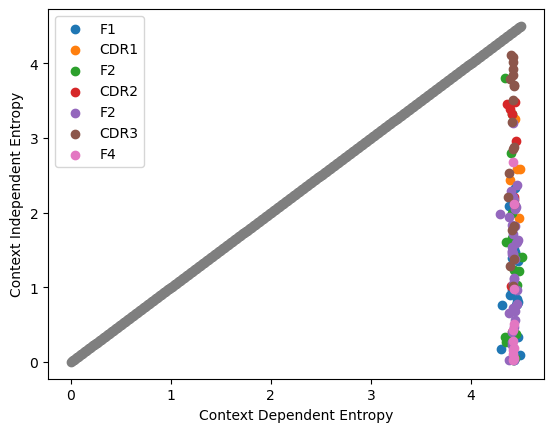

In [34]:
vec1=list(cde)
vec2=list(cie)

plt.scatter(vec1[:b_cdr1], vec2[:b_cdr1], label='F1')
plt.scatter(vec1[b_cdr1:e_cdr1], vec2[b_cdr1:e_cdr1], label='CDR1')
plt.scatter(vec1[e_cdr1: b_cdr2], vec2[e_cdr1: b_cdr2], label='F2')
plt.scatter(vec1[b_cdr2:e_cdr2], vec2[b_cdr2:e_cdr2], label='CDR2')
plt.scatter(vec1[e_cdr2: b_cdr3], vec2[e_cdr2: b_cdr3], label='F2')
plt.scatter(vec1[b_cdr3:e_cdr3], vec2[b_cdr3:e_cdr3], label='CDR3')
plt.scatter(vec1[e_cdr3:], vec2[e_cdr3:], label='F4')
plt.scatter(np.arange(0,max(vec1),0.01),np.arange(0,max(vec1),0.01))
plt.ylabel("Context Independent Entropy")
plt.xlabel("Context Dependent Entropy")
plt.legend()

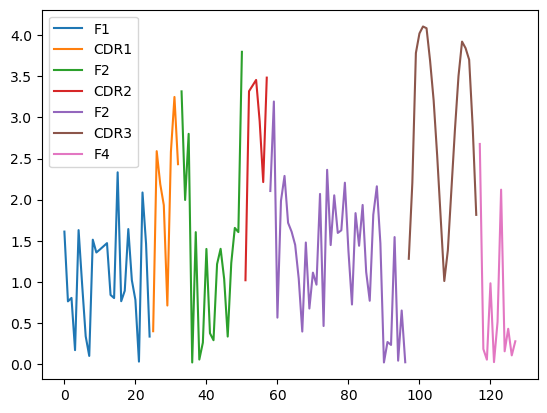

In [35]:
ent_p_al = np.array(cie)
import matplotlib.pyplot as plt
plt.plot(np.arange(b_cdr1), ent_p_al[:b_cdr1], label='F1')
plt.plot(np.arange(b_cdr1,e_cdr1), ent_p_al[b_cdr1:e_cdr1], label='CDR1')
plt.plot(np.arange(e_cdr1, b_cdr2), ent_p_al[e_cdr1: b_cdr2], label='F2')
plt.plot(np.arange(b_cdr2,e_cdr2), ent_p_al[b_cdr2:e_cdr2], label='CDR2')
plt.plot(np.arange(e_cdr2, b_cdr3), ent_p_al[e_cdr2: b_cdr3], label='F2')
plt.plot(np.arange(b_cdr3,e_cdr3), ent_p_al[b_cdr3:e_cdr3], label='CDR3')
plt.plot(np.arange(e_cdr3, NA), ent_p_al[e_cdr3:], label='F4')
plt.legend()

In [36]:
# rewrite a loss function
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = tokenizer.encode(inputs, return_tensors="pt") # get token id for input sequence
#         # forward pass
#         outputs = model(**inputs)
#         token_ids = tokenizer.encode(seqs[s], return_tensors='pt')
#     #train
#     # take the model and calculate the MaskedLMOutput, take its logits
#     # which are in a matrix with size # tokens x # symbols 
#     ## (note: it's a single-sequence embedding)
#     out = trainer.model(token_ids)
#         logits = outputs.get("logits")
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0], device=model.device))
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         # loss = nn.CrossEntropyLoss()
#         return (loss, outputs) if return_outputs else loss

## Direct Coupling Analysis

<https://github.com/KIT-MBS/pydca/tree/master>

In [37]:
def slice_couplings(couplings = None, site_pair=None, num_site_states=None, seqs_len = None):
    """Constructs couplings array suitable for computing two-site-model fields as well 
    as DI scores. 

    Parameters
    ----------
        couplings : np.array
            A 1 array of couplings excluding gap state couplings
        site_pair : tuple
            Site pair (i, j) such that j > i with o <= i < seqs_len
        num_site_states : int 
            Number of site states for sequence 
        seqs_len : int 
            Length of sequences in MSA data 
    """
    i, j = site_pair[0], site_pair[1]
    q = num_site_states
    qm1 = q - 1
    pair_loc = int((seqs_len * (seqs_len - 1)/2) - (seqs_len - i) * ((seqs_len - i) - 1)/2  + j  - i - 1)
    start_indx = pair_loc * qm1 * qm1  
    end_indx = start_indx + qm1 * qm1
    couplings_ij = np.zeros((q, q), dtype = np.float64)
    couplings_tmp = couplings[start_indx:end_indx]
    couplings_ij[:q-1, :q-1]  = np.reshape(couplings_tmp, shape = (q-1, q-1))
    return couplings_ij 

## Interpret results

In [ ]:
# slight discrepancy in naming
# train-i-j-k -> {n_head}-{n_layer}-{rand_ind}
# model name: n_layer, n_head,rand_ind

In [8]:
# transform json files into dataframe

def read_log(filepath):
    js = pd.read_json(filepath)
    s = js["best_model_checkpoint"][0] # the directory of best checkpoint
    best_model_checkpoint = int(s.split("-")[-1]) # the number of steps at which the best metric is obtained
    lst = filepath.split("checkpoint-")
    lst = lst[1].split("/")
    total_steps = int(lst[0])
    df = pd.json_normalize(js["log_history"])
    n = len(df)
    # dataframe contianing eval loss
    odd_indx = np.array([i for i in range(n) if i%2 == 1])
    df1 = df.loc[odd_indx,:]
    # dataframe contianing train loss
    even_indx = np.array([i for i in range(n) if i%2 == 0])
    df2 = df.loc[even_indx,:]

    df1 = df1[["step", "eval_loss"]]
    df2 = df2[["step", "loss"]]
    df3 = df1.join(df2.set_index('step'), on='step')
    return df3,js["best_metric"][0],best_model_checkpoint, total_steps

In [25]:
path = generate_path(1,2,0)
plot_df, best_metric,best_model_checkpoint,total_steps = read_log(path)

In [50]:
unfinished_2 = []
finished2 = []
for i in range(1,5):
    for j in range(1,5):
        for k in range(10):
            try:
                _, _,best_model_checkpoint,total_steps = read_log(generate_path(i,j,k))
                if total_steps < best_model_checkpoint + 500:
                    print((i,j,k))
                    unfinished_2.append((i,j,k))
            except FileNotFoundError:
                print("insided finished 02")
                finished2.append((i,j,k))

insided finished 02
insided finished 02
insided finished 02
(1, 2, 0)
insided finished 02
(1, 2, 8)
insided finished 02
(1, 3, 1)
insided finished 02
(1, 3, 9)
(1, 4, 0)
(1, 4, 4)
insided finished 02
(1, 4, 8)
insided finished 02
insided finished 02
(2, 2, 0)
insided finished 02
insided finished 02
(2, 2, 7)
(2, 2, 8)
(2, 2, 9)
insided finished 02
insided finished 02
insided finished 02
(2, 4, 0)
insided finished 02
insided finished 02
insided finished 02
(2, 4, 8)
insided finished 02
(3, 2, 0)
insided finished 02
insided finished 02
(3, 3, 4)
insided finished 02
insided finished 02
(3, 4, 4)
insided finished 02
insided finished 02
insided finished 02
(4, 2, 0)
(4, 2, 2)
(4, 2, 4)
insided finished 02
(4, 2, 7)
insided finished 02
(4, 2, 9)
insided finished 02
insided finished 02
insided finished 02
(4, 4, 0)
(4, 4, 4)
insided finished 02


In [38]:
def list2txt(lst,filepath):
    """
    save content of a list into text file
    Args:
        lst: a list of tuples
        filepath: a string indicating the path of a text file
    """
    # clear file content before writing
    if os.path.isfile(filepath):
        open(filepath, 'w').close()
    with open(filepath, 'w') as f:
        for line in lst:
            f.write(str(line)+"\n")

In [58]:
list2txt(unfinished_2,"round_11.txt")

In [53]:
for m in range(len(unfinished_2)):
    i,j,k = unfinished_2[m]
    s = "-".join(["train",str(i),str(j),str(k)])
    train_path = "finished/"+s
    new_train_path = f"./train-11-{m+1}"
    os.rename(train_path, new_train_path)

In [57]:
for m in range(len(unfinished_2)):
    i,j,k = unfinished_2[m]
    modelname = os.listdir(f"./train-11-{m+1}/model")[0]
    print(modelname)
    train_path = f"./train-11-{m+1}/model/"+modelname
    new_train_path = f"./backup_model/{modelname}"
    os.rename(train_path, new_train_path)

02-01-00
02-01-08
03-01-01
03-01-09
04-01-00
04-01-04
04-01-08
02-02-00
02-02-07
02-02-08
02-02-09
04-02-00
04-02-08
02-03-00
03-03-04
04-03-04
02-04-00
02-04-02
02-04-04
02-04-07
02-04-09
04-04-00
04-04-04


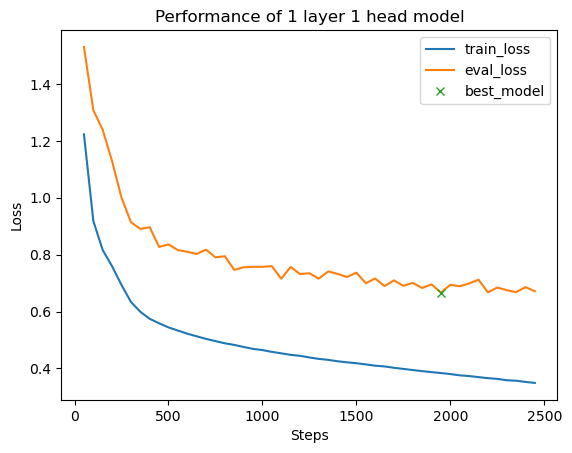

In [22]:
plt.plot(plot_df[["step"]], plot_df[["loss", "eval_loss"]], label=["train_loss","eval_loss"])
plt.plot(best_model_checkpoint,best_metric,"x", label="best_model") # Note each eval is not evenly spread over steps
plt.title("Performance of 1 layer 1 head model")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def training_report():
    train_finished = []
    continue_training = []
    for i in range(1,5):
    # i is the number of heads
        for j in range(1,5):
            #j is the number of layers
            for k in range(2):
                # k is the index of split datasets
                if (i-1)*8+(j-1)*2+k+1 not in [1,2,7,17,19,25]:
                    jspath = generate_path(i,j,k+1)
                    plot_df, best_metric, best_model_checkpoint,total_steps = read_log(jspath)
                    eval_loss = np.array(plot_df[["eval_loss"]])
                    if earlystop_detection(eval_loss):
                        print(f"{i} heads {j} layers model {k} early stopped at {best_metric}")
                        train_finished.append((i,j,k))
                    else:
                        print(best_model_checkpoint,total_steps)
                        print(f"{i} heads {j} layers model {k} more training required")
                        continue_training.append((i,j,k))

    return train_finished,continue_training

In [ ]:
jspath = generate_path(1,3,2)
plot_df, best_metric, best_model_checkpoint, total_steps = read_log(jspath)
lst = jspath.split("checkpoint-")
lst = lst[1].split("/")
total_steps = int(lst[0])

## Compare with RBM

In [50]:
# Open the file in binary mode
import pickle
with open('prob.pkl', 'rb') as file:
      
    # Call load method to deserialze
    probs_rbm = pickle.load(file)

In [51]:
np.array(probs_rbm).shape

(3146, 128, 21)

In [ ]:
voab_mlm = {{
  "<s>": 0,
  "</s>": 2,
  "<pad>": 1,
  "<unk>": 3,
  "<mask>": 4,
  "A": 5,
  "C": 6,
  "D": 7,
  "E": 8,
  "F": 9,
  "G": 10,
  "H": 11,
  "I": 12,
  "K": 13,
  "L": 14,
  "M": 15,
  "N": 16,
  "P": 17,
  "Q": 18,
  "R": 19,
  "S": 20,
  "T": 21,
  "V": 22,
  "W": 23,
  "Y": 24
}}

In [47]:
vocab_rbm = {'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19,
 '-': 20}

In [52]:
probs_rbm = np.array(probs_rbm)[:,:,:-1]

In [59]:
probs_mlm = np.array(probs)[:,1:-1,5:]

In [60]:
probs_mlm.shape

(3146, 128, 20)

In [71]:
ref  = 40
diff = probs_mlm[ref]-probs_rbm[ref]

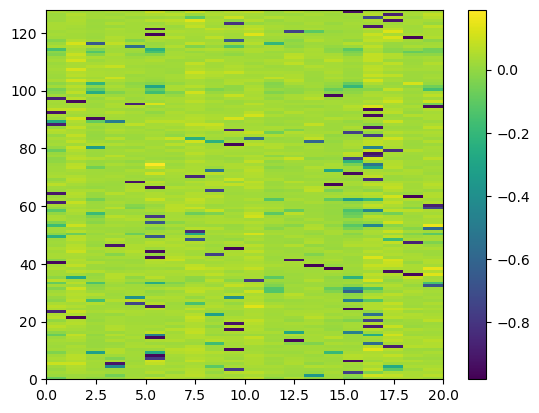

In [72]:
heatmap = plt.pcolor(diff) 
plt.colorbar(heatmap)

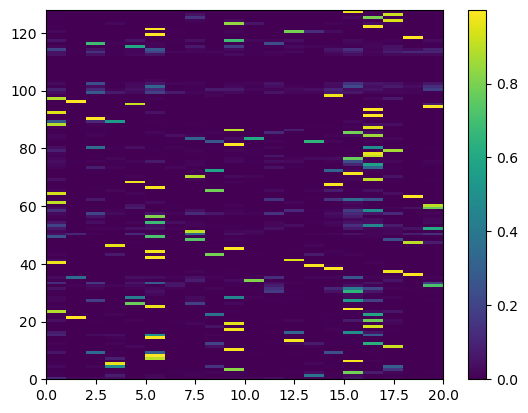

In [73]:
heatmap = plt.pcolor(probs_rbm[ref]) 
plt.colorbar(heatmap)

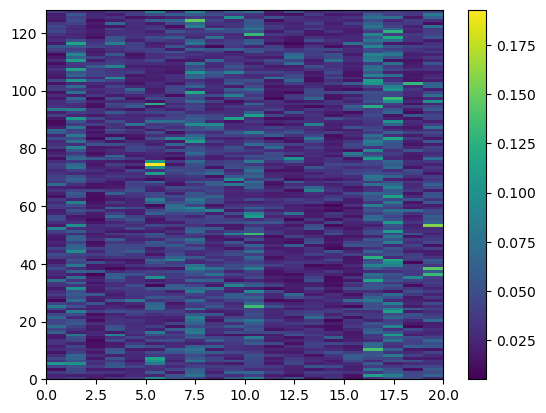

In [74]:
heatmap = plt.pcolor(probs_mlm[ref]) 
plt.colorbar(heatmap)

### Check specific sites

In [79]:
def prob_at_site(index, probs=probs_mlm):
    # index: integer, position at aligned sequences
    # return: an array of n_seqx25
    n_seq = len(probs)
    output = np.zeros((n_seq,20))
    for i in range(n_seq):
        output[i,:] = probs_mlm[i][index,:]
    return output

(array([3.290e+02, 0.000e+00, 7.600e+01, 0.000e+00, 0.000e+00, 4.400e+01,
        2.000e+00, 1.120e+02, 1.000e+00, 0.000e+00, 6.200e+01, 1.300e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 4.300e+01,
        2.700e+01, 2.435e+03]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. ]),
 <BarContainer object of 20 artists>)

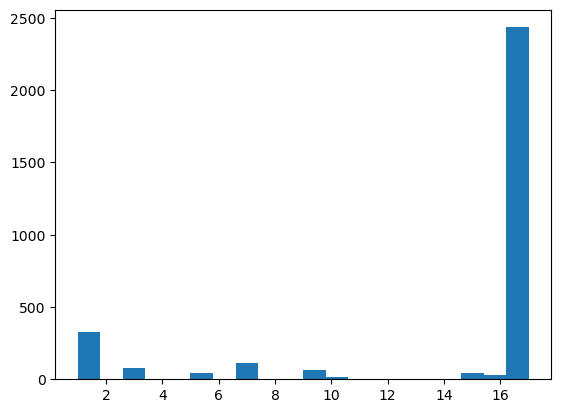

In [83]:
output = prob_at_site(97)
output = np.argmax(output, axis=1)
plt.hist(output, bins=20)

## Extract attentions

In [ ]:
model = RobertaForMaskedLM.from_pretrained("./model/1-1-1")

In [ ]:
attentions_list = []
for i in range(len(seqs_al)):
    token_ids = tokenizer.encode(seqs_al[0], return_tensors='pt')
    out = model(token_ids)
    attentions = out.attentions[0][0][0] # 130x130 array
    attentions_list.append(attentions)

In [ ]:
for i in range(len(seqs_al)):
    a = attentions_list[i]
    attentions_list[i] = a.detach().numpy()

In [ ]:
attentions_list = np.array(attentions_list)

In [ ]:
mat = np.mean(attentions_list, axis=0)

In [ ]:
# mat = np.zeros((130,130))
# for i in range(130):
#     for j in range(130):
#         mean = 0
#         for s in range(len(seqs_al)):
#             mean += attentions_list[s][i,j]
#         mean = mean/len(seqs_al)
#         mat[i,j] = mean
#         print(i,j)

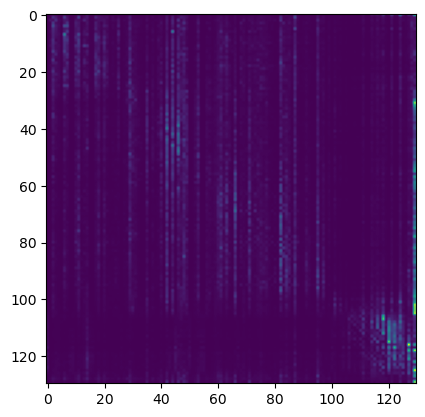

In [ ]:
plt.imshow(mat)

In [ ]:
ref = 12 # example VH 1
# ref=1584/1571 # example VH 2
# ref = 370 # PDB: 7KFX